# Here my target is to analyze how noise estimation and camera characterization can be done statistically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
My functions for simulating camera and noisy images.
'''

'\nMy functions for simulating camera and noisy images.\n'

In [3]:
'''
1. Noiseless Gaussian 2D image
'''
def generate_gaussian_2d(size=512, sigma=1, rate=10000): 

    # size: size of the image (size x size)
    # sigma: standard deviation of the Gaussian
    # rate: number of photons per second at each pixel

    x = np.linspace(0, size - 1, size)
    y = np.linspace(0, size - 1, size)
    x, y = np.meshgrid(x, y)
    # Define center
    mu_x, mu_y = size // 2, size // 2
    # Calculate the Gaussian map
    gaussian_map = np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))
    return gaussian_map * rate



''' 
2. Uniformly illuminated 2D image
'''
def generate_uniform_2d(size=512, intensity=100):

    # size: size of the image (size x size)
    # intensity: number of photons per second per pixel

    uniform_map = np.full((size, size), intensity)
    return uniform_map



In [4]:

''' 
3. Adding noise to the image
'''
class SensorNoiseGenerator:
    def __init__(self, sens_sigma, read_sigma, dc_bias, clean_image_array, exp_t, dark_rate, 
                 sens_seed=None, read_seed=None, shot_seed=None, dark_seed=None):
        
        # sens_sigma: standard deviation of pixel sensitivity variations
        # read_sigma: standard deviation of read noise
        # dc_bias: DC bias level of the sensor
        # clean_image_array: 2D numpy array of the noiseless image
        # exp_t: exposure time in seconds   
        # dark_rate: dark current rate (electrons per second per pixel)
        # sens_seed, read_seed, shot_seed, dark_seed: seeds for random number generators for reproducibility


        # Initialize parameters
        self.sens_sigma = sens_sigma
        self.read_sigma = read_sigma
        self.dc_bias = dc_bias
        self.clean_image_array = clean_image_array
        self.exp_t = exp_t
        self.dark_rate = dark_rate
        self.shape = clean_image_array.shape
        
        # Store seeds for reproducibility
        self.sens_seed = sens_seed
        self.read_seed = read_seed
        self.shot_seed = shot_seed
        self.dark_seed = dark_seed

    def _get_rng(self, seed):
        """Helper to manage independent RNG streams."""
        return np.random.default_rng(seed)

    def pixel_sensitivity(self):
        return self._get_rng(seed = self.sens_seed).normal(1.0, self.sens_sigma, self.shape)

    def read_noise(self):
        return self._get_rng(seed = self.read_seed).normal(self.dc_bias, self.read_sigma, self.shape)

    def shot_noise(self, arr=None):
        target = (self.clean_image_array * self.exp_t) if arr is None else arr
        return self._get_rng(seed = self.shot_seed).poisson(target).astype(float)
    
    def dark_noise(self):
        mu_dark = self.dark_rate * self.exp_t
        return self._get_rng(seed = self.dark_seed).poisson(mu_dark, self.shape).astype(float)
    


In [5]:
''' 
4. Digitizing the image: converting electrons to ADU and clipping
'''
class SensorDigitizer:
    def __init__(self, bit_depth, gain_dB, full_well_capacity, image_electrons):

        # bit_depth: bit depth of the sensor (e.g., 12 for 12-bit)
        # gain_dB: gain in decibels
        # full_well_capacity: maximum number of electrons the sensor can hold   
        # image_electrons: 2D numpy array of the image (can be noisy or noiseless) in electrons

        # Initialize parameters
        self.max_adu = 2**bit_depth - 1
        self.full_well_capacity = full_well_capacity
        self.gain_optimum = full_well_capacity / self.max_adu  # e-/ADU
        self.gain = self.gain_optimum / (10**(gain_dB / 20))

        self.image_electrons = image_electrons

    def electron_to_adu_converter(self):
        return self.image_electrons / self.gain

    def adu_clipper(self):
        clipped_adu = np.clip(self.electron_to_adu_converter(), 0, self.max_adu)
        whole_clipeed_adu = np.floor(clipped_adu).astype(np.uint16)
        return whole_clipeed_adu
    


In [168]:
inter_pix_sens_sigma = 0.02

read_noise_sigma = 5
dc_bias_level = 12

gain_in_dB = 30

bit_depth = 8
FWC = 15000  # full well capacity in electrons

Exposure_TIME = 0.0 #s
dark_current_rate = 0.0 # electrons per second per pixel

num_bias_frames = 50

In [169]:
# generate master bias and subtract it from the flats before calculating RON and PTC

Bias_frame = np.zeros((512,512), dtype=np.uint16)
bias_list = []

a = np.random.randint(0, 10000, 1) #inter-pixel sensitivity is constant (fixed pattern noise)

for z in range(num_bias_frames):
    # Generate a noiseless uniform image
    clean_image = generate_uniform_2d(size=512, intensity=0)  # 0 photons/s/pixel

    b,c,d = np.random.randint(0, 10000, 3) # Random seeds for noise generation
    # Add noise
    noise_gen = SensorNoiseGenerator(
        sens_sigma=inter_pix_sens_sigma,
        read_sigma=read_noise_sigma,
        dc_bias=dc_bias_level,
        clean_image_array=clean_image,
        exp_t=Exposure_TIME,
        dark_rate=dark_current_rate,
        sens_seed=a,
        read_seed=b,
        shot_seed=c,
        dark_seed=d
    )

    noisy_image = noise_gen.pixel_sensitivity() * (noise_gen.shot_noise() + noise_gen.dark_noise()) + noise_gen.read_noise()

    # Digitize the image
    digitizer = SensorDigitizer(
        bit_depth=bit_depth,
        gain_dB=gain_in_dB,
        full_well_capacity=FWC,
        image_electrons=noisy_image
    )

    digitized_image = digitizer.adu_clipper()
    Bias_frame = Bias_frame + digitized_image
    bias_list.append(digitized_image)
    z += 1

master_bias = Bias_frame / num_bias_frames
# print(master_bias)
print(f"Master dc bias mean ADU: {np.mean(master_bias)}")
print(f"Master dc bias mean e-: {np.mean(master_bias) * digitizer.gain}")
A = np.array([(bi - master_bias)**2 for bi in bias_list])
# print(A)
# print(np.sum(A, axis=(0)))
master_RON_var = (np.sum(A, axis=(0)) ) / (num_bias_frames - 1)
master_RON_arr = np.sqrt(master_RON_var)

master_RON_mean = np.mean(master_RON_arr)
master_RON_median = np.median(master_RON_arr)
print(f"Master bias std ADU: {master_RON_mean}")
print(f"Master bias median ADU: {master_RON_median}")
print('RON in e-:', master_RON_mean * digitizer.gain)


Master dc bias mean ADU: 5.963762893676757
Master dc bias mean e-: 11.093573040714785
Master bias std ADU: 2.6600590885680386
Master bias median ADU: 2.657373261900034
RON in e-: 4.948144370886217


Max ADU: 255
Full well capacity: 15000 e-
Optimum gain: 58.82 e-/ADU
Using gain: 1.86 e-/ADU


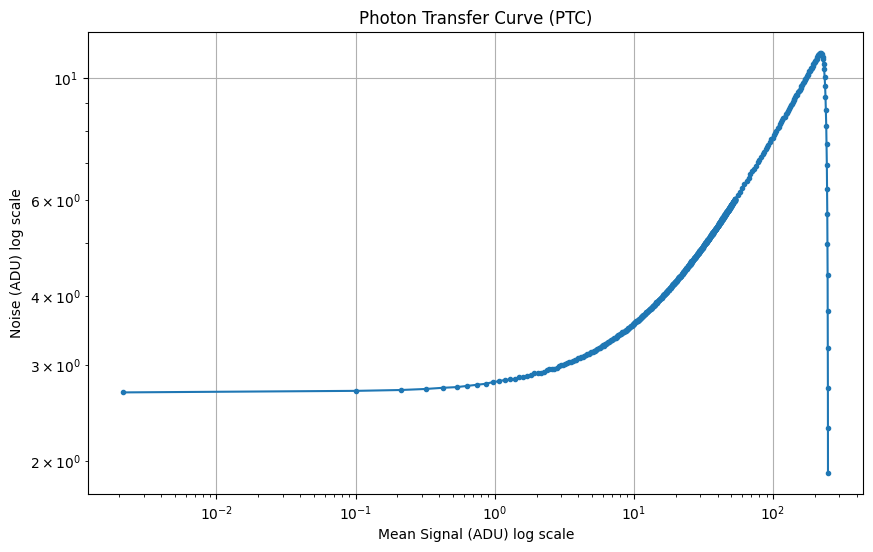

In [170]:
''' 
Simulating photon transfer curve (PTC)
'''
# exposure_times_0 = np.linspace(0.0, 0.0000000001, 50)  # Exposure times from 1 ms to 1 s
exposure_times_1 = np.linspace(0.0, 1, 500)  # Exposure times from 1 ms to 1 s

exposure_times_2 = np.linspace(1, 5, 100)  # Exposure times from 0.1 s to 10 s
# exposure_times_3 = np.linspace(0.01, 10, 50)  # Exposure times from 1 s to 100 s
exposure_times = np.concatenate((exposure_times_1, exposure_times_2))  # , exposure_times_3))

mean_signals = []
var_signals = []

for i, exp_t in enumerate(exposure_times):
    # Generate a noiseless uniform image
    clean_image = generate_uniform_2d(size=512, intensity=100)  # 1000 photons/s/pixel

    Flat_pairs = []

    for j in range(2): # 2 sets of flat frames for each level of light signal

        b,c,d = np.random.randint(0, 10000, 3) # Random seeds for noise generation
        # Add noise
        noise_gen = SensorNoiseGenerator(
            sens_sigma=inter_pix_sens_sigma,
            read_sigma=read_noise_sigma,
            dc_bias=dc_bias_level,
            clean_image_array=clean_image,
            exp_t=exp_t,
            dark_rate=dark_current_rate,
            sens_seed=a,
            read_seed=b,
            shot_seed=c,
            dark_seed=d
        )

        noisy_image = noise_gen.pixel_sensitivity() * (noise_gen.shot_noise() + noise_gen.dark_noise()) + noise_gen.read_noise()

        # Digitize the image
        digitizer = SensorDigitizer(
            bit_depth=bit_depth,
            gain_dB=gain_in_dB,
            full_well_capacity=FWC,
            image_electrons=noisy_image
        )

        digitized_image = digitizer.adu_clipper()
        Flat_pairs.append(digitized_image)
    
    # Calculate mean and standard deviation of the signal
    # Convert to float to allow negative values and avoid wrap-around
    f1 = Flat_pairs[0].astype(np.float32)
    f2 = Flat_pairs[1].astype(np.float32)
    mean_of_flats_ADU = np.mean((f1 + f2) / 2) - np.mean(master_bias)
    var_of_flats_ADUsq = np.var(f1 - f2) / 2

    mean_signals.append(mean_of_flats_ADU)
    var_signals.append(var_of_flats_ADUsq)


print(f"Max ADU: {digitizer.max_adu}")
print(f"Full well capacity: {digitizer.full_well_capacity} e-")
print(f"Optimum gain: {digitizer.gain_optimum:.2f} e-/ADU")
print(f"Using gain: {digitizer.gain:.2f} e-/ADU")

plt.figure(figsize=(10, 6))
plt.loglog(mean_signals, np.sqrt(var_signals), marker='.')
plt.title('Photon Transfer Curve (PTC)')
plt.xlabel('Mean Signal (ADU) log scale')
plt.ylabel('Noise (ADU) log scale')
plt.grid()
plt.show()




Read Out Noise from minimum variance:
2.6687803 ADU
2.6687803 ADU
4.9643674 : RON in electrons

Fitting the linear region to get gain and RON:
[0.53615769 7.4982909 ]
Fitted gain: 1.87 e-/ADU
RON: 5.11 electrons


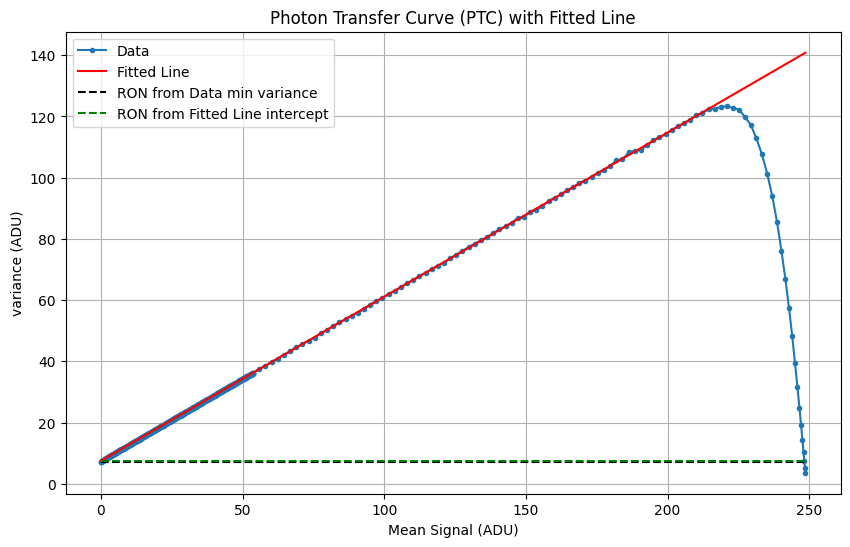

In [171]:
print("Read Out Noise from minimum variance:")
print(np.sqrt(min(var_signals[:50])), "ADU")
print(np.sqrt(var_signals[0]), 'ADU')
print(np.sqrt(min(var_signals[:50])) * digitizer.gain, ": RON in electrons")

############################

print("\nFitting the linear region to get gain and RON:")
# fitting the linear area to get the gain value
def linear_fit(x, m, c):
    return m * x + c

# x = np.array(mean_signals[105:220])
x = np.array(mean_signals)[(np.array(mean_signals) < 180) & (np.array(mean_signals) > 90)]
y = np.array(var_signals)[(np.array(mean_signals) < 180) & (np.array(mean_signals) > 90)]
# y = np.array(var_signals[105:220])
from scipy.optimize import curve_fit
params, covariance = curve_fit(linear_fit, x, y)
m_fit, c_fit = params
print(params)
print(f"Fitted gain: {1/m_fit:.2f} e-/ADU")
print(f"RON: {np.sqrt(c_fit)/m_fit:.2f} electrons")


plt.figure(figsize=(10, 6))
plt.plot(mean_signals, var_signals, marker='.', label='Data')

X = np.linspace(0, max(mean_signals), 1000)
plt.plot(X, linear_fit(X, m_fit, c_fit), color='red', label='Fitted Line')
plt.hlines(var_signals[0], 0, max(mean_signals), colors='black', linestyles='dashed', label='RON from Data min variance')
plt.hlines(c_fit, 0, max(mean_signals), colors='green', linestyles='dashed', label='RON from Fitted Line intercept')

plt.title('Photon Transfer Curve (PTC) with Fitted Line')
plt.xlabel('Mean Signal (ADU)')
plt.ylabel('variance (ADU)')
plt.grid()
plt.legend()
plt.show()


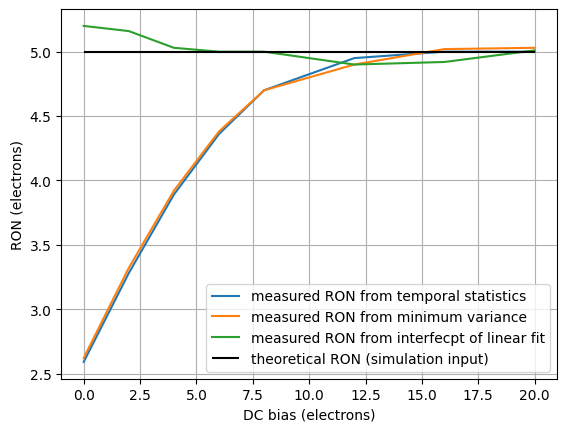

In [172]:
DC_biases = [0, 2, 4, 6, 8, 12, 16, 20]
RON_from_temporal_stats = [2.59, 3.28, 3.89, 4.36, 4.7, 4.95, 5, 5]
RON_from_mininum_variance = [2.62, 3.32, 3.92, 4.38, 4.7, 4.9, 5.02, 5.03]
RON_from_intercept = [5.2, 5.16, 5.03, 5, 5, 4.9, 4.92, 5.01]

# showing behaviour of different methods
plt.plot(DC_biases, RON_from_temporal_stats, label='measured RON from temporal statistics')
plt.plot(DC_biases, RON_from_mininum_variance, label='measured RON from minimum variance')
plt.plot(DC_biases, RON_from_intercept, label='measured RON from interfecpt of linear fit')
plt.hlines(5, xmin=min(DC_biases), xmax=max(DC_biases), color='k', label='theoretical RON (simulation input)')
plt.legend()
plt.grid()
plt.xlabel('DC bias (electrons)')
plt.ylabel('RON (electrons)')
plt.show()


In [173]:
## Dark noise estimation next ?